In [1]:
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

# imports
import matplotlib
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import subprocess
import textwrap
import string
import sys

from collections import Counter, defaultdict, OrderedDict
from datetime import datetime
from diversity import Metacommunity
from file_read_backwards import FileReadBackwards
from glob import glob
from itertools import combinations, product
from Levenshtein import distance
from matplotlib import pyplot as plt
from os.path import expanduser, exists, isdir
from os import chdir
from scipy.stats import linregress, ttest_ind_from_stats, mannwhitneyu as mwu
from scipy.stats.mstats import gmean
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR, SVR # SVR in principle has lower error; NuSVR in principle has the simpler model; in practice these are the same
from subprocess import call, check_output
from tqdm.notebook import tqdm
from urllib.request import urlopen

from IPython.core.display import display, HTML  # <-- Make screen wider
display(HTML("<style>.container { width:75% !important; }</style>"))

plt.ion()

colors = OrderedDict([ # ~color brewer 9 color palette
    ("red", "#d53e4f"),
    ("dark orange", "#f46d43"),
    ("light orange", "#fdae61"),
    ("dark yellow", "#fee08b"),
    ("light yellow", "#ffffbf"),
    ("yellow green", "#e6f598"),
    ("light green", "#abdda4"),
    ("blue green", "#66c2a5"),
    ("blue", "#3288bd"),
    # ("gray", "#cccccc"),
    ("purple", "#8F90C6"),
    ])

In [2]:
runid_info_list = [ 
    ('SRR960281', 'L10_Y1_D0',  'female'), ('SRR960282', 'L10_Y1_D28', 'female'), ('SRR960283', 'L10_Y1_D7',  'female'), ('SRR960284', 'L11_Y1_D0',  'female'), 
    ('SRR960285', 'L11_Y1_D28', 'female'), ('SRR960286', 'L11_Y1_D7',  'female'), ('SRR960287', 'L12_Y1_D0',  'female'), ('SRR960288', 'L12_Y1_D28', 'female'), 
    ('SRR960289', 'L12_Y1_D7',  'female'), ('SRR960290', 'L13_Y1_D0',  'female'), ('SRR960291', 'L13_Y1_D28', 'female'), ('SRR960292', 'L13_Y1_D7',  'female'), 
    ('SRR960293', 'L14_Y1_D0',  'female'), ('SRR960294', 'L14_Y1_D28', 'female'), ('SRR960295', 'L14_Y1_D7',  'female'), ('SRR960296', 'L1_Y1_D0',   'male'), 
    ('SRR960298', 'L1_Y1_D7',   'male'),   ('SRR960299', 'L1_Y1_D7',   'male'),   ('SRR960303', 'L2_Y1_D28',  'female'), ('SRR960306', 'L3_Y1_D28',  'male'), 
    ('SRR960297', 'L1_Y1_D28',  'male'),   ('SRR960300', 'L1_Y1_D7',   'male'),   ('SRR960301', 'L1_Y1_D7',   'male'),   ('SRR960302', 'L2_Y1_D0',   'female'), 
    ('SRR960304', 'L2_Y1_D7',   'female'), ('SRR960305', 'L3_Y1_D0',   'male'),   ('SRR960307', 'L3_Y1_D7',   'male'),   ('SRR960310', 'L4_Y1_D7',   'male'), 
    ('SRR960311', 'L5_Y1_D0',   'female'), ('SRR960313', 'L5_Y1_D7',   'female'), ('SRR960314', 'L6_Y1_D0',   'male'),   ('SRR960323', 'L9_Y1_D0',   'female'), 
    ('SRR960324', 'L9_Y1_D28',  'female'), ('SRR960331', 'T11_Y1_D7',  'male'),   ('SRR960332', 'T12_Y1_D0',  'female'), ('SRR960334', 'T12_Y1_D7',  'female'), 
    ('SRR960308', 'L4_Y1_D0',   'male'),   ('SRR960309', 'L4_Y1_D28',  'male'),   ('SRR960312', 'L5_Y1_D28',  'female'), ('SRR960315', 'L6_Y1_D28',  'male'), 
    ('SRR960316', 'L6_Y1_D7',   'male'),   ('SRR960317', 'L7_Y1_D0',   'male'),   ('SRR960318', 'L7_Y1_D28',  'male'),   ('SRR960319', 'L7_Y1_D7',   'male'), 
    ('SRR960320', 'L8_Y1_D0',   'male'),   ('SRR960321', 'L8_Y1_D28',  'male'),   ('SRR960322', 'L8_Y1_D7',   'male'),   ('SRR960325', 'L9_Y1_D7',   'female'), 
    ('SRR960326', 'T10_Y1_D0',  'male'),   ('SRR960327', 'T10_Y1_D28', 'male'),   ('SRR960328', 'T10_Y1_D7',  'male'),   ('SRR960329', 'T11_Y1_D0',  'male'), 
    ('SRR960330', 'T11_Y1_D28', 'male'),   ('SRR960333', 'T12_Y1_D28', 'female'), ('SRR960335', 'T13_Y1_D0',  'male'),   ('SRR960336', 'T13_Y1_D28', 'male'), 
    ('SRR960338', 'T14_Y1_D0',  'male'),   ('SRR960337', 'T13_Y1_D7',  'male'),   ('SRR960339', 'T14_Y1_D28', 'male'),   ('SRR960340', 'T14_Y1_D7',  'male'), 
    ('SRR960341', 'T1_Y1_D0',   'male'),   ('SRR960342', 'T1_Y1_D28',  'male'),   ('SRR960343', 'T1_Y1_D7',   'male'),   ('SRR960344', 'T1_Y2_D0',   'male'), 
    ('SRR960345', 'T1_Y2_D28',  'male'),   ('SRR960346', 'T1_Y2_D7',   'male'),   ('SRR960347', 'T2_Y1_D0',   'female'), ('SRR960348', 'T2_Y1_D28',  'female'), 
    ('SRR960349', 'T2_Y1_D7',   'female'), ('SRR960350', 'T2_Y2_D0',   'female'), ('SRR960351', 'T2_Y2_D28',  'female'), ('SRR960352', 'T2_Y2_D7',   'female'), 
    ('SRR960353', 'T3_Y1_D0',   'female'), ('SRR960354', 'T3_Y1_D28',  'female'), ('SRR960355', 'T3_Y1_D7',   'female'), ('SRR960356', 'T3_Y2_D0',   'female'), 
    ('SRR960357', 'T3_Y2_D28',  'female'), ('SRR960358', 'T3_Y2_D7',   'female'), ('SRR960359', 'T4_Y1_D0',   'female'), ('SRR960360', 'T4_Y1_D28',  'female'), 
    ('SRR960361', 'T4_Y1_D7',   'female'), ('SRR960364', 'T4_Y2_D7',   'female'), ('SRR960365', 'T5_Y1_D0',   'male'),   ('SRR960366', 'T5_Y1_D28',  'male'), 
    ('SRR960370', 'T5_Y2_D7',   'male'),   ('SRR960371', 'T6_Y1_D0',   'female'), ('SRR960372', 'T6_Y1_D0',   'female'), ('SRR960373', 'T6_Y1_D28',  'female'), 
    ('SRR960375', 'T7_Y1_D0',   'male'),   ('SRR960376', 'T7_Y1_D0',   'male'),   ('SRR960377', 'T7_Y1_D28',  'male'),   ('SRR960380', 'T8_Y1_D0',   'male'), 
    ('SRR960381', 'T8_Y1_D28',  'male'),   ('SRR960382', 'T8_Y1_D7',   'male'),   ('SRR960383', 'T9_Y1_D0',   'male'),   ('SRR960384', 'T9_Y1_D28',  'male'), 
    ('SRR960362', 'T4_Y2_D0',   'female'), ('SRR960363', 'T4_Y2_D28',  'female'), ('SRR960367', 'T5_Y1_D7',   'male'),   ('SRR960368', 'T5_Y2_D0',   'male'), 
    ('SRR960369', 'T5_Y2_D28',  'male'),   ('SRR960374', 'T6_Y1_D7',   'female'), ('SRR960378', 'T7_Y1_D7',   'male'),   ('SRR960379', 'T8_Y1_D0',   'male'), 
    ('SRR960385', 'T9_Y1_D7',   'male') ]

In [3]:
flu_repertoire_dir = "Flu_Ig_complete_repertoires/"

In [4]:
curated_runid_info_list = []
sample_size = 1e5
srr_filenames = set([ "recon_input_" + i[0] + "_hIgG_annotated.txt" for i in runid_info_list])
# check sizes of repertoires
for runid_info in runid_info_list:
    srr, info, sex = runid_info
    flu_repertoire_file = flu_repertoire_dir + "recon_input_" + srr + "_hIgG_annotated.txt"
    tot = 0
    if not exists(flu_repertoire_file):
#         print("missing\t%s" % srr_filename)
        continue
    for line in open(flu_repertoire_file):
        cdr3, no = line.strip().split()
        no = float(no)
        tot += no
    if tot >= sample_size:
        curated_runid_info_list.append(runid_info)
#     print("%s\t%s" % (str(int(tot)).rjust(7), srr_filename))
print(len(runid_info_list), "->", len(curated_runid_info_list), "files with ≥%.0e sequences" % sample_size)

105 -> 90 files with ≥1e+05 sequences


Get `d0_igg_T_srrs` and `d7_igg_T_srrs`:

In [5]:
d0_igg_T_srrs = []
d7_igg_T_srrs = []
for srr, time, sex in curated_runid_info_list:
    if not time.startswith("T"): continue
    day = time.split("D")[-1]
    if day == "0":
        d0_igg_T_srrs.append(srr)
    elif day == "7":
        d7_igg_T_srrs.append(srr)

Get filenames for d0 and d7 IgG TIV:

In [6]:
# get IDs that have both a d0 and a d7
# define ID as T<no>_Y<no>---i.e., a person and a year
info_list = list(zip(*curated_runid_info_list))[1]
ids = sorted(list(set([info.rsplit("_", 1)[0] for info in info_list])))
T_ids_with_d0_and_d7 = []
for id_ in ids:
    if  "%s_D0" % id_ in info_list and \
        "%s_D7" % id_ in info_list and \
        id_.startswith("T"):
        T_ids_with_d0_and_d7.append(id_)
# note: T_ids_with_d0_and_d7 ensures the order we want

# get SRRs for d0 and d7
id_d0_igg_T_srr_hash = defaultdict(list)
id_d7_igg_T_srr_hash = defaultdict(list)
d0_igg_TIV_srrs = []
d7_igg_TIV_srrs = []
for id_ in T_ids_with_d0_and_d7:              # the following could more efficiently be done instead with a hash
    for srr, info, sex in curated_runid_info_list:
        if   "%s_D0" % id_ == info:
            id_d0_igg_T_srr_hash[id_].append((srr, info))
            d0_igg_TIV_srrs.append(srr)
        elif "%s_D7" % id_ == info:
            id_d7_igg_T_srr_hash[id_].append((srr, info))
            d7_igg_TIV_srrs.append(srr)

# get filenames for these
d0_filename_igg_T = sorted(["recon_input_" + srr + "_hIgG_annotated.txt" for srr in d0_igg_T_srrs])
d7_filename_igg_T = sorted(["recon_input_" + srr + "_hIgG_annotated.txt" for srr in d7_igg_T_srrs])

In [7]:
T_ids_with_d0_and_d7

['T10_Y1',
 'T12_Y1',
 'T13_Y1',
 'T14_Y1',
 'T1_Y1',
 'T1_Y2',
 'T2_Y1',
 'T2_Y2',
 'T3_Y1',
 'T5_Y1',
 'T5_Y2',
 'T6_Y1',
 'T7_Y1',
 'T8_Y1']

In [8]:
alpha_diversity_master_file = flu_repertoire_dir + "alpha_diversity_master_file.txt"

header = ["id", "day_0", "d0_file", "0D_d0", "0Ds_d0", "id_confirm", "day_7", "d7_file", "0D_d7", "0Ds_d7"]
outlines = []
for id_ in T_ids_with_d0_and_d7:
    # find SRR for d0 and d7
    for srr, info, _ in runid_info_list:
        if info.startswith(id_):
            if   info.endswith("D0"): d0_srr = srr
            elif info.endswith("D7"): d7_srr = srr
    # find the lines in the master file that goes with these and extract the 0D from each of them
    d0_srr_containing_string = "recon_input_" + d0_srr + "_hIgG_annotated_1e5"
    d7_srr_containing_string = "recon_input_" + d7_srr + "_hIgG_annotated_1e5"
    outline = []
    # ...for d0
    for line in FileReadBackwards(alpha_diversity_master_file): # ensures the latest entry
        if d0_srr_containing_string in line:
            exec("Ds_hash, D_hash = " + line.split("\t")[3])
            outline += [id_, "d0", d0_srr_containing_string, float(D_hash['0.0D']), float(Ds_hash['0.0Ds'])]
            break
    # ...for d7
    for line in FileReadBackwards(alpha_diversity_master_file): # ensures the latest entry
        if d7_srr_containing_string in line:
            exec("Ds_hash, D_hash = " + line.split("\t")[3])
            outline += (id_, "d7", d7_srr_containing_string, float(D_hash['0.0D']), float(Ds_hash['0.0Ds']))
            break
    outlines.append(outline)
df = pd.DataFrame(outlines, columns=header)
df["0D_pct_change"] = (df["0D_d7"]/df["0D_d0"] - 1)*100
df["0Ds_pct_change"] = (df["0Ds_d7"]/df["0Ds_d0"] - 1)*100
display(df)
print(  "Median 0D pct_change, d0-d7:   %.2f%%" % np.median( sorted(list(df["0D_pct_change"])) )  )
print(  "Median 0Ds pct_change, d0-d7: %.2f%%" % np.median( sorted(list(df["0Ds_pct_change"])) )  )
print()
print("0D MWU p-value:  %.2e" % mwu(df["0D_d7"], df["0D_d0"]).pvalue)
print("0Ds MWU p-value: %.2e" % mwu(df["0Ds_d7"], df["0Ds_d0"]).pvalue)

,id,day_0,d0_file,0D_d0,0Ds_d0,id_confirm,day_7,d7_file,0D_d7,0Ds_d7,0D_pct_change,0Ds_pct_change
0,T10_Y1,d0,recon_input_SRR960326_hIgG_annotated_1e5,468400.0,8312.0,T10_Y1,d7,recon_input_SRR960328_hIgG_annotated_1e5,33690.0,5592.0,-92.807430,-32.723773
1,T12_Y1,d0,recon_input_SRR960332_hIgG_annotated_1e5,24670.0,6405.0,T12_Y1,d7,recon_input_SRR960334_hIgG_annotated_1e5,24540.0,3957.0,-0.526956,-38.220141
2,T13_Y1,d0,recon_input_SRR960335_hIgG_annotated_1e5,39860.0,7584.0,T13_Y1,d7,recon_input_SRR960337_hIgG_annotated_1e5,53980.0,9046.0,35.423984,19.277426
3,T14_Y1,d0,recon_input_SRR960338_hIgG_annotated_1e5,21080.0,5462.0,T14_Y1,d7,recon_input_SRR960340_hIgG_annotated_1e5,30160.0,4504.0,43.074004,-17.539363
4,T1_Y1,d0,recon_input_SRR960341_hIgG_annotated_1e5,88510.0,8863.0,T1_Y1,d7,recon_input_SRR960343_hIgG_annotated_1e5,66200.0,10160.0,-25.206191,14.633871
5,T1_Y2,d0,recon_input_SRR960344_hIgG_annotated_1e5,38140.0,10500.0,T1_Y2,d7,recon_input_SRR960346_hIgG_annotated_1e5,134000.0,4442.0,251.337179,-57.695238
6,T2_Y1,d0,recon_input_SRR960347_hIgG_annotated_1e5,81780.0,13780.0,T2_Y1,d7,recon_input_SRR960349_hIgG_annotated_1e5,34660.0,4476.0,-57.618000,-67.518142
7,T2_Y2,d0,recon_input_SRR960350_hIgG_annotated_1e5,95050.0,6966.0,T2_Y2,d7,recon_input_SRR960352_hIgG_annotated_1e5,27580.0,5390.0,-70.983693,-22.624175
8,T3_Y1,d0,recon_input_SRR960353_hIgG_annotated_1e5,41950.0,7155.0,T3_Y1,d7,recon_input_SRR960355_hIgG_annotated_1e5,286600.0,4617.0,583.194279,-35.471698
9,T5_Y1,d0,recon_input_SRR960365_hIgG_annotated_1e5,260800.0,5222.0,T5_Y1,d7,recon_input_SRR960367_hIgG_annotated_1e5,26760.0,3796.0,-89.739264,-27.307545


Median 0D pct_change, d0-d7:   39.25%
Median 0Ds pct_change, d0-d7: -24.97%

0D MWU p-value:  6.29e-01
0Ds MWU p-value: 8.24e-03


In [9]:
infiles = [flu_repertoire_dir + i for i in os.listdir(flu_repertoire_dir) if i.startswith("recon_input") and i.endswith("txt")]

In [10]:
def make_S(seqs):
    S = np.identity(len(seqs))
    for i, j in combinations(range(len(seqs)), 2):
        s_ij = 0.3**distance(seqs[i], seqs[j])       # from Arora 2022 PNAS
        S[i][j] = s_ij
        S[j][i] = s_ij
    return S

In [11]:
metacommunities = {}
for infile in tqdm(infiles):
    srr = infile.split("/")[-1].split("_")[2]
    labels, counts = zip(*[line.split() for line in open(infile)])
    counts = [int(i) for i in counts]
    counts = pd.DataFrame({srr: counts})
    m = Metacommunity(counts)
    S = make_S(labels)
    mS = Metacommunity(counts, similarity=S)
    metacommunities[srr] = (m, mS)

  0%|          | 0/35 [00:00<?, ?it/s]

In [12]:
for srr in metacommunities.keys():
    m, mS = metacommunities[srr]
    D0 = m.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    D0S = mS.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    print(f"{srr}\t{D0:.0f}\t{D0S:.3f}")

SRR960382	13338	7472.230
SRR960346	10211	4442.405
SRR960347	23041	13777.507
SRR960352	11080	5360.931
SRR960353	15143	7236.449
SRR960332	12712	6323.216
SRR960338	10956	5550.214
SRR960340	11726	4503.928
SRR960380	15310	7621.759
SRR960367	9996	3795.872
SRR960334	8347	3956.828
SRR960337	16039	8984.941
SRR960335	14199	7528.276
SRR960331	9550	4298.571
SRR960343	18568	10136.983
SRR960349	10127	4524.793
SRR960358	10491	4844.637
SRR960374	13114	5494.952
SRR960365	10814	5221.629
SRR960385	9798	3782.561
SRR960355	11986	4617.179
SRR960376	10321	6494.276
SRR960341	17648	8808.579
SRR960350	12019	6965.995
SRR960379	14888	7751.972
SRR960364	6580	2693.323
SRR960326	16614	8312.331
SRR960378	7626	2852.622
SRR960361	8817	2826.506
SRR960344	17169	10502.633
SRR960328	13269	5535.347
SRR960370	10609	4953.919
SRR960368	9996	5700.570
SRR960371	5607	3010.770
SRR960372	9788	5017.723


In [13]:
id_srr_hash = {}
for i, row in df.iterrows():
    id_ = row.id
    d0_srr = row.d0_file.split("_")[2]
    d7_srr = row.d7_file.split("_")[2]
    id_srr_hash[id_] = (d0_srr, d7_srr)

In [14]:
d0_D0s = []
d7_D0s = []
d0_D0Ss = []
d7_D0Ss = []
for id_, (d0_srr, d7_srr) in id_srr_hash.items():
    # for day 0 (d0)
    m, mS = metacommunities[d0_srr]
    D0 = m.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    D0S = mS.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    d0_D0s.append(D0)
    d0_D0Ss.append(D0S)
    # for day 7 (d7)
    m, mS = metacommunities[d7_srr]
    D0 = m.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    D0S = mS.subcommunity_diversity(viewpoint=0, measure='alpha')[0]
    d7_D0s.append(D0)
    d7_D0Ss.append(D0S)    

We need to perform [Recon](https://github.com/ArnaoutLab/Recon):

In [15]:
error_bars_file = flu_repertoire_dir + "error_bar_parameters.txt"

srr_recon_D0_hash = {}
for infile in tqdm(infiles):
    out1 = infile.replace("recon_input", "reconstructed")
    out2 = infile.replace("recon_input", "recon_output")
    reconstruction_cmd = f'recon.py -R -o "{out1}" "{infile}"'
    subprocess.check_output(reconstruction_cmd, shell=True)
    get_D_numbers_cmd = f'recon.py -D -Q 0 -b "{error_bars_file}" -o "{out2}" "{out1}"'
    # print(get_D_numbers_cmd)
    subprocess.check_output(get_D_numbers_cmd, shell=True)
    sample_name, results = open(out2, "r").readlines()[-1].split("\t", 1)
    obs_0D, est_0D, est_0D_lower, est_0D_upper = [float(i) for i in results.strip().split()]
    srr = sample_name.split("/")[-1].split("_")[1]
    srr_recon_D0_hash[srr] = (est_0D, est_0D_lower, est_0D_upper)

  0%|          | 0/35 [00:00<?, ?it/s]

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f

In [16]:
d0_recon_D0s = []
d7_recon_D0s = []
for id_, (d0_srr, d7_srr) in id_srr_hash.items():
    est_0D, est_0D_lower, est_0D_upper = srr_recon_D0_hash[d0_srr]
    d0_recon_D0s.append(est_0D)
    est_0D, est_0D_lower, est_0D_upper = srr_recon_D0_hash[d7_srr]
    d7_recon_D0s.append(est_0D)

<IPython.core.display.Javascript object>


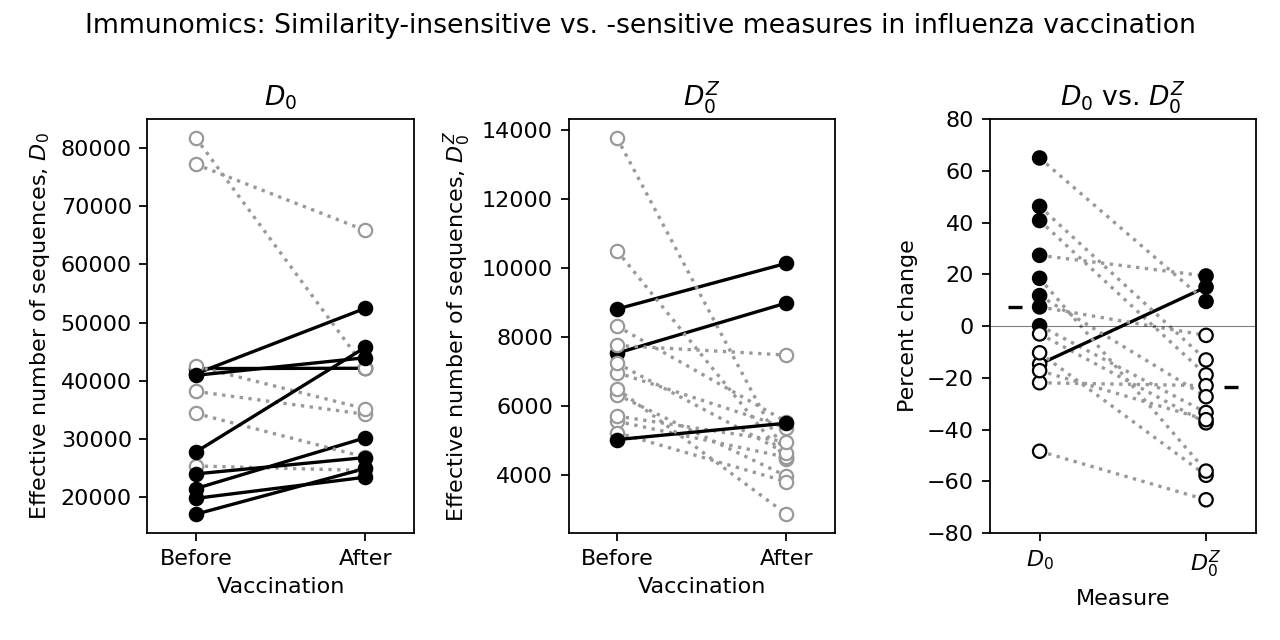

In [118]:
datas  = (d0_recon_D0s, d7_recon_D0s), (d0_D0Ss, d7_D0Ss)
names  = ("D", "DZ")
labels = ("$D_0$", "$D^Z_0$")
up_colors = ("black", "black")
down_colors = ("#999", "#999")
up_facecolors = ("black", "black")
down_facecolors = ("white", "white")
up_alpha = 1.
down_alpha = 1.

deltas = []
colors = []

fig, axs = plt.subplots(ncols=3, figsize=(8,4))

for i, (data, name, label) in enumerate(zip(datas, names, labels)):
    ax = axs[i]
    delta = []; c = []
    for y in zip(data[0], data[1]):
        delta.append((y[1] - y[0])/y[0])
        if y[1] > y[0]: 
            facecolor = up_facecolors[i]
            edgecolor = up_colors[i]
            linecolor = edgecolor
            ls        = "-"
            alpha = up_alpha
            c.append(up_facecolors[i])
        else:
            facecolor = down_facecolors[i]
            edgecolor = down_colors[i]
            linecolor = edgecolor
            ls        = ":"
            alpha = down_alpha
            c.append(down_facecolors[i])
        ax.plot([0, 7], list(y), color=linecolor, ls=ls, alpha=alpha)
        ax.scatter([0, 7], list(y), marker="o", facecolors=facecolor, 
                    edgecolors=edgecolor, zorder=1000, alpha=alpha)
    deltas.append(delta)
    colors.append(c)
    ax.set_xticks([0, 7])
    ax.set_xticklabels(["Before", "After"])
    ax.set_xlim(-2, 9)
    ax.set_xlabel("Vaccination")
    ax.set_ylabel(f"Effective number of sequences, {labels[i]}")
    ax.set_title(labels[i])

deltas = np.array(deltas)

# plot of percent change
ax = axs[2]
for i in 100*deltas.T: 
    if i[0] < i[1]: 
        color = "black"
        ls = "-"
    else: 
        color = "#999"
        ls = ":"
    plt.plot(i, color=color, ls=ls, zorder=-1000)
ax.scatter(len(deltas[0])*[0,], 100*deltas[0], facecolors=colors[0], 
            edgecolors="black", zorder=1000)
ax.scatter(len(deltas[1])*[1,], 100*deltas[1], facecolors=colors[1], 
            edgecolors="black", zorder=1000)
ax.scatter([-0.15,], np.mean(deltas[0])*100, color="black", marker="_", 
           zorder=1000)
ax.scatter([1.15,], np.mean(deltas[1])*100, color="black", marker="_", 
           zorder=1000)
ax.set_xlim(-0.3, 1.3)
ax.set_xticks([0, 1], labels)
ax.set_ylim(np.array([-0.8, 0.8])*100)
ax.set_xlabel("Measure")
ax.set_ylabel("Percent change")
ax.set_title(f"{labels[0]} vs. {labels[1]}")
ax.axhline(0, color="black", zorder=-1000, alpha=0.5, lw=0.5)

plt.suptitle(f"Immunomics: Similarity-insensitive vs. -sensitive measures in influenza vaccination")

plt.tight_layout()
plt.savefig(flu_repertoire_dir + "immunomics_fig_112223.pdf", 
            transparent=True)
plt.show()